# Notice

To have an accurate and dirct comparison, we use the following files from [ADAPT-VQE repository](https://github.com/mayhallgroup/adapt-vqe/tree/master/src)
* `pyscf_helper.py` to create the Hamiltonian from the geometry
* `operator_pools.py` to generate ansatz pool (as discussed in [ADAPT-GCM paper](https://arxiv.org/abs/2312.07691))


Due to upgrades in `openfermion`, `get_sparse_operator()` is not in `openfermion.linalg`. For `operator_pools.py`, please add the following at the top
```
import openfermion.linalg as transforms 
```

Due to upgrades in `pyscf`, `molden` is not in `pyscf` directly. In line 3 of `pyscf_helper.py`, please remove the import of `molden` and add the following at the top
```
from pyscf.tools import molden
```
If the atomic unit is used (such as $H_4$ and $H_6$ in [ADAPT-GCM paper](https://arxiv.org/abs/2312.07691)), please add the following code in line 229 in `pyscf_helper.py`
```
mol.unit = 'B'  # (B, b, Bohr, bohr, AU, au) or (A, a, Angstrom, angstrom, Ang, ang)
```

In [1]:
try:
    import operator_pools
    import pyscf_helper
except:
    raise Except("See ReadMe. Please go to https://github.com/mayhallgroup/adapt-vqe/tree/master/src to download required files.")

## ADAPT-GCM
from adapt_gcm import *
from moles import *

/Users/zhen002/opt/anaconda3/envs/gcmtest/lib/python3.10/site-packages/pyscf/dft/libxc.py:771: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, corresponding to the original definition by Stephens et al. (issue 1480) and the same as the B3LYP functional in Gaussian. To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


## Construct the molecule and select GCM inputs

The file `moles.py` records the geometries of the other molecules used in the paper. Please change the UNIT accordingly. 

To avoid numerical instability, we can use `make_orth=True` to orthogonalize the basis vector set classically. But to simulate quantum computing, this option should be `False`.

As discussed in the paper, we do not optimize parameters in ADAPT-GCM, so set `theta=np.pi/4` for all bases. Other good options for `theta` can be 0.001 etc.

In [2]:
## Option for the pool and GCM
mol = LiH() # LiH, BeH2

make_orth = False # If classically orthogonalize the basis vector set
theta = np.pi/4 # constant phase parameter for all basis vectors

Let `PySCF` and `pyscf_helper.py` do the rest of the computation for the Hamiltonian

In [3]:
mol.initialize()
mol_name = mol.mol_name
mol_name_pic = mol.mol_name_pic
n_orb = mol.n_orb
n_a = mol.n_a
n_b = mol.n_b
fermi_ham = mol.fermi_ham
reference_ket = mol.reference_ket
file_prefix = 'Demo_Data/'

 ---------------------------------------------------------
                                                          
                      Using Pyscf:
                                                          
 ---------------------------------------------------------
                                                          


/Users/zhen002/opt/anaconda3/envs/gcmtest/lib/python3.10/site-packages/pyscf/lib/misc.py:142: UserWarning: OpenMP is not available. Setting omp_threads to 1 has no effects.
  warnings.warn('OpenMP is not available. '


converged SCF energy = -7.86114942364805

System and Method:
[('Li', (0, 0, 0)), ('H', (0, 0, 1.62))]
Basis set                                      :      sto-3g
Number of Orbitals                             :         6
Number of electrons                            :         4
Nuclear Repulsion                              :    0.9799577980 
Electronic SCF energy                          :   -8.8411072216 
SCF Energy                                     :   -7.8611494236
 AO->MO
 NElectrons:    2    2
 ecore:   0.00000000
 ERIs in the active-space:
(6, 6, 6, 6)    0.01036800 Mb
 n_orb:    6
 n_a  :    2
 n_b  :    2
 HF Energy:  -7.86114942
 Build reference state with    2 alpha and    2 beta electrons [0, 2, 1, 3]
 State    0:  -7.88194453 au


## Select the operator pool
By default, use the spin-adapted pool

In [4]:
pool = operator_pools.singlet_GSD()
pool.init(n_orb, n_occ_a=n_a, n_occ_b=n_b, n_vir_a=n_orb-n_a, n_vir_b=n_orb-n_b)

 Form singlet GSD operators
 Number of operators:  330


## Start ADAPT-GCM

`change_tol` is a convergence criteria. When the changes of the estimated ground-state energies are within `change_tol` for `X` amount of iterations, the algorithm declares convergence. The value of 'X' dependes on the size of pool. It is set to $10\%$ of the size of the pool in line 353 of `adapt_gcm.py` (i.e., variable `flat_iter`).

In the fucntion return, `GCM_EVS` records the lowest eigenvalues in all iterations, `OneShot_EV` records the eigenvalue from the final one-shot GCM, `GCM_Indices` is the indices of selected ansatzes in the operator pool, `GCM_DIFFS` is the error of estimated ground-state energies in all iterations, `OneShot_Diff` is the error from one-shot GCM, and `GCM_BASIS_SIZE` is the size of bases in all iterations.

In [5]:
[GCM_EVS,OneShot_EV, GCM_Indices, GCM_DIFFS, OneShot_Diff, GCM_BASIS_SIZE] = adapt_gcm(fermi_ham, 
                                pool,  reference_ket, theta,
                                change_tol    = 1e-6,
                                max_iter = 200,
                                make_orth = make_orth,
                                file_prefix  = file_prefix)

 Generate Sparse Matrices for operators in pool


------------ Iter 0 Start ------------
 Sum of gradients = 0.200449
 Largest gradient = 0.175572

 Choose ansatz 193
 Number of saved prod bases 0 , H matrix size (2, 2)
 GCM Energy:  -7.875951590367650
 GCM error : 5.992944e-03
------------ Iter 0 Finish -----------


------------ Iter 1 Start ------------
 Sum of gradients = 0.113813
 Largest gradient = 0.036321

 Choose ansatz 191
 Number of saved prod bases 1 , H matrix size (4, 4)
 GCM Energy:  -7.876589701142397
 GCM error : 5.354833e-03
------------ Iter 1 Finish -----------


------------ Iter 2 Start ------------
 Sum of gradients = 0.201486
 Largest gradient = 0.163237

 Choose ansatz 328
 Number of saved prod bases 2 , H matrix size (6, 6)
 GCM Energy:  -7.876589701142395
 GCM error : 5.354833e-03
------------ Iter 2 Finish -----------


------------ Iter 3 Start ------------
 Sum of gradients = 0.108586
 Largest gradient = 0.035333

 Choose ansatz 35
 Number of saved prod ba

 GCM Energy:  -7.881715291846168
 GCM error : 2.292422e-04
------------ Iter 26 Finish -----------


------------ Iter 27 Start ------------
 Sum of gradients = 0.099500
 Largest gradient = 0.036920
 Small changes have happended for 14/30 iterations

 Choose ansatz 308
 Number of saved prod bases 27 , H matrix size (56, 56)
 GCM Energy:  -7.881715291846168
 GCM error : 2.292422e-04
------------ Iter 27 Finish -----------


------------ Iter 28 Start ------------
 Sum of gradients = 0.089394
 Largest gradient = 0.025702
 Small changes have happended for 15/30 iterations

 Choose ansatz 1
 Number of saved prod bases 28 , H matrix size (58, 58)
 GCM Energy:  -7.881729440554790
 GCM error : 2.150935e-04
------------ Iter 28 Finish -----------


------------ Iter 29 Start ------------
 Sum of gradients = 2.002463
 Largest gradient = 0.863843

 Choose ansatz 16
 Number of saved prod bases 29 , H matrix size (60, 60)
 GCM Energy:  -7.881792692028079
 GCM error : 1.518420e-04
------------ Iter

 Sum of gradients = 0.398422
 Largest gradient = 0.152683

 Choose ansatz 162
 Number of saved prod bases 54 , H matrix size (110, 110)
 GCM Energy:  -7.881944534016436
 GCM error : 1.139622e-11
------------ Iter 54 Finish -----------


------------ Iter 55 Start ------------
 Sum of gradients = 1.280385
 Largest gradient = 0.713966

 Choose ansatz 21
 Number of saved prod bases 55 , H matrix size (112, 112)
 GCM Energy:  -7.881944534027634
 GCM error : 1.980638e-13
------------ Iter 55 Finish -----------


------------ Iter 56 Start ------------
 Sum of gradients = 0.693958
 Largest gradient = 0.366084
 Small changes have happended for 0/27 iterations

 Choose ansatz 0
 Number of saved prod bases 56 , H matrix size (114, 114)
 GCM Energy:  -7.881944534027699
 GCM error : 1.332268e-13
------------ Iter 56 Finish -----------


------------ Iter 57 Start ------------
 Sum of gradients = 0.849831
 Largest gradient = 0.424549
 Small changes have happended for 1/27 iterations

 Choose ansat

 Number of saved prod bases 79 , H matrix size (160, 160)
 GCM Energy:  -7.881944534027794
 GCM error : 3.819167e-14
------------ Iter 79 Finish -----------


------------ Iter 80 Start ------------
 Sum of gradients = 0.384688
 Largest gradient = 0.311557
 Small changes have happended for 24/25 iterations
 Converged due to tiny changes 4.441e-15 in eigenvalues in 25 iterations
 ADAPT-GCM Converged
 Orthogonalization:  False
 Number of ansatzes:  80
 Number of basis used in the final iteration of GCM: 160
 Number of basis used in the one-shot GCM : 82
 *True Energy :  -7.881944534027832
 *GCM Finished:  -7.881944534027794
 *GCM error          3.819167e-14
 *One-shot GCM error 1.312205e-05
 ----------- Final ansatzes ----------- 
    #        Coeff               Term
    0   0.78539816      (1' 1' 5  5  ) : 1010 1010 
    1   0.78539816      (1' 1' 4  4  ) : 1010 1010 
    2   0.78539816      (4' 4' 5  5  ) : 1010 1010 
    3   0.78539816      (1' 0' 2  0  ) : 0000 1111 1010 0101 1001 0

## Plot the errors

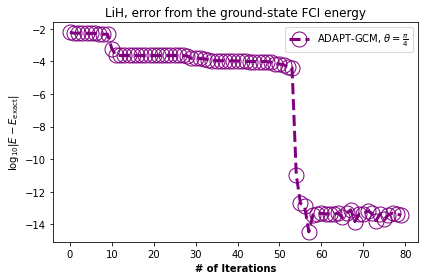

In [9]:
import matplotlib.pyplot as plt
iter_range = list(range( 0, len(GCM_DIFFS) ))
plt.plot(iter_range, np.log10(np.abs(GCM_DIFFS))[iter_range],
         marker='o',markerfacecolor='none',color='purple',
         linestyle='--',linewidth=3,markersize=15, label=r'ADAPT-GCM, $\theta = \frac{\pi}{4}$')
plt.xlabel(r'# of Iterations', fontweight='bold')
plt.ylabel(r'$\log_{10}\|E - E_{\rm exact}\|$')
plt.title('LiH, error from the ground-state FCI energy')
plt.legend()
plt.tight_layout()
plt.show()

You can see ADAPT-GCM reach the $10^{-14}$ error in less than 60 iterations WITHOUT any parameter optimization

## Counting gates of ansatzes

In the above computation, we still use `SciPy` to simulate the unitary evolution in quantum circuits. To estimate the quantum resources, we need to use `Qiskit`.

In [12]:
from qiskit.quantum_info import Pauli, SparsePauliOp
from qiskit.quantum_info import Statevector
from qiskit_algorithms import TimeEvolutionProblem
from qiskit.quantum_info import Operator
from qiskit_algorithms.time_evolvers.trotterization import TrotterQRTE
from qiskit import transpile

Let us say we want transfer the ansatz with Index `193` in the operator pool to a circuit. We first make it a Qiskit object from an OpenFermion object.

In [13]:
def format_qubit_operator(qubit_op, n_qubits, real_coeff = False):
    # qubit_op: openfermion.ops.operators.qubit_operator.QubitOperator
    # n_qubits: int
    # return e.g.,  {'YZXIIIII': 0.5j, 'XZYIIIII': -0.5j}
    imaginary_flag = False
    coefs = []
    paulis = []
    for term, term_coef in qubit_op.terms.items():
        # Create a list of 'I' for all qubits
        formatted_term = ['I'] * n_qubits
        for qubit, pauli in term:
            formatted_term[qubit] = pauli
        if real_coeff:
            if term_coef != np.imag(term_coef):
                imaginary_flag = True
            term_coef = np.imag(term_coef)
        coefs.append(term_coef)
        paulis.append(''.join(formatted_term))
    return coefs, paulis, imaginary_flag

ind = 193
jw_op = of.transforms.jordan_wigner(pool.fermi_ops[ind])
op_coefs, op_paulis, if_imag = format_qubit_operator(jw_op, n_orb*2, real_coeff = True)
qiskit_op = SparsePauliOp(op_paulis, coeffs=-1*np.array(op_coefs) )
qiskit_op

SparsePauliOp(['IIXXIIIIIIYX', 'IIYYIIIIIIYX', 'IIYXIIIIIIXX', 'IIXYIIIIIIXX', 'IIYXIIIIIIYY', 'IIXYIIIIIIYY', 'IIXXIIIIIIXY', 'IIYYIIIIIIXY'],
              coeffs=[ 0.08838835+0.j, -0.08838835+0.j, -0.08838835+0.j, -0.08838835+0.j,
  0.08838835+0.j,  0.08838835+0.j,  0.08838835+0.j, -0.08838835+0.j])

Now, we do the evoltion of the this operator to obtain the matrix exponential using Trotter

In [14]:
initial_state = Statevector.from_label('0'*(n_orb*2))
problem = TimeEvolutionProblem(qiskit_op, initial_state=initial_state, time=theta)
## to circuit
trotter = TrotterQRTE(num_timesteps=1)
result = trotter.evolve(problem)
result.evolved_state.decompose().draw()

»
 q_0: »
      »
 q_1: »
      »
 q_2: »
      »
 q_3: »
      »
 q_4: »
      »
 q_5: »
      »
 q_6: »
      »
 q_7: »
      »
 q_8: »
      »
 q_9: »
      »
q_10: »
      »
q_11: »
      »
«      ┌──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Finally, we transpile the circuit into basis gates and optimize the gate counts

In [15]:
basis_gate_set = ['cx', 'rz', 'sx']
trans_circ = transpile(result.evolved_state, basis_gates=basis_gate_set, 
                       optimization_level=3, seed_transpiler=7)
opt_counts = dict(trans_circ.count_ops())
opt_counts

{'rz': 52, 'cx': 39, 'sx': 36}

That is to say, the matrix exponential of the ansatz index `193` requires 39 CNOT gates.